In [3]:
import os
import glob
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [5]:
act_folder = '/home/chengzhang/Multimodal-Quantization/evaluation/activations/llava-7b'

In [6]:
def plot_layer_2(left: np.ndarray, right: np.ndarray, titles: list[str], outliers_rate: float = 0.01):
    channels = left.shape[-1]
    outliers = round(channels * outliers_rate)

    left_outliers = left.argsort()[-outliers:]
    right_outliers = right.argsort()[-outliers:]
    left_spec_outliers = set(left_outliers) - set(right_outliers)
    right_spec_outliers = set(right_outliers) - set(left_outliers)
    print(len(left_spec_outliers))

    left_colors = np.tile(np.array([0x1f, 0x77, 0xb4]) / 255, (channels, 1))
    right_colors = np.tile(np.array([0x1f, 0x77, 0xb4]) / 255, (channels, 1))
    for idx in left_outliers:
        left_colors[idx] = np.array([0x2c, 0xa0, 0x2c]) / 255
    for idx in right_outliers:
        right_colors[idx] = np.array([0x2c, 0xa0, 0x2c]) / 255
    for idx in left_spec_outliers:
        left_colors[idx] = np.array([0xd6, 0x27, 0x28]) / 255
    for idx in right_spec_outliers:
        right_colors[idx] = np.array([0xd6, 0x27, 0x28]) / 255
    
    max_val = max(left.max(), right.max())

    print(left.argmax(), left.max())
    print(right.argmax(), right.max())

    groups = (channels + 512 - 1) // 512

    plt.figure(figsize=(15, 2 * groups))

    def plot_group(tensor, colors, start, stop, idx, title=None):
        ax = plt.subplot(groups, 2, idx)
        ax.bar(np.arange(start, stop), tensor[start:stop], width=np.ones(stop - start), color=colors[start:stop])
        # ax.set_ylim(0, np.ceil(max_val))
        ax.set_ylim(0, max_val)
        # ax.set_ylim(0, 0.2)
        ax.set_xlim(start, start + 512)
        ax.set_xticks(np.arange(start, start + 513, 64))
        if title is not None:
            ax.set_title(title)

    for group_id in range(groups):
        start = group_id * 512
        stop = min(start + 512, channels)
        plot_group(left, left_colors, start, stop, group_id * 2 + 1, titles[1] if group_id == 0 else None)
        plot_group(right, right_colors, start, stop, group_id * 2 + 2, titles[2] if group_id == 0 else None)

    plt.suptitle(titles[0])

464
9966 0.5483
6450 4.1


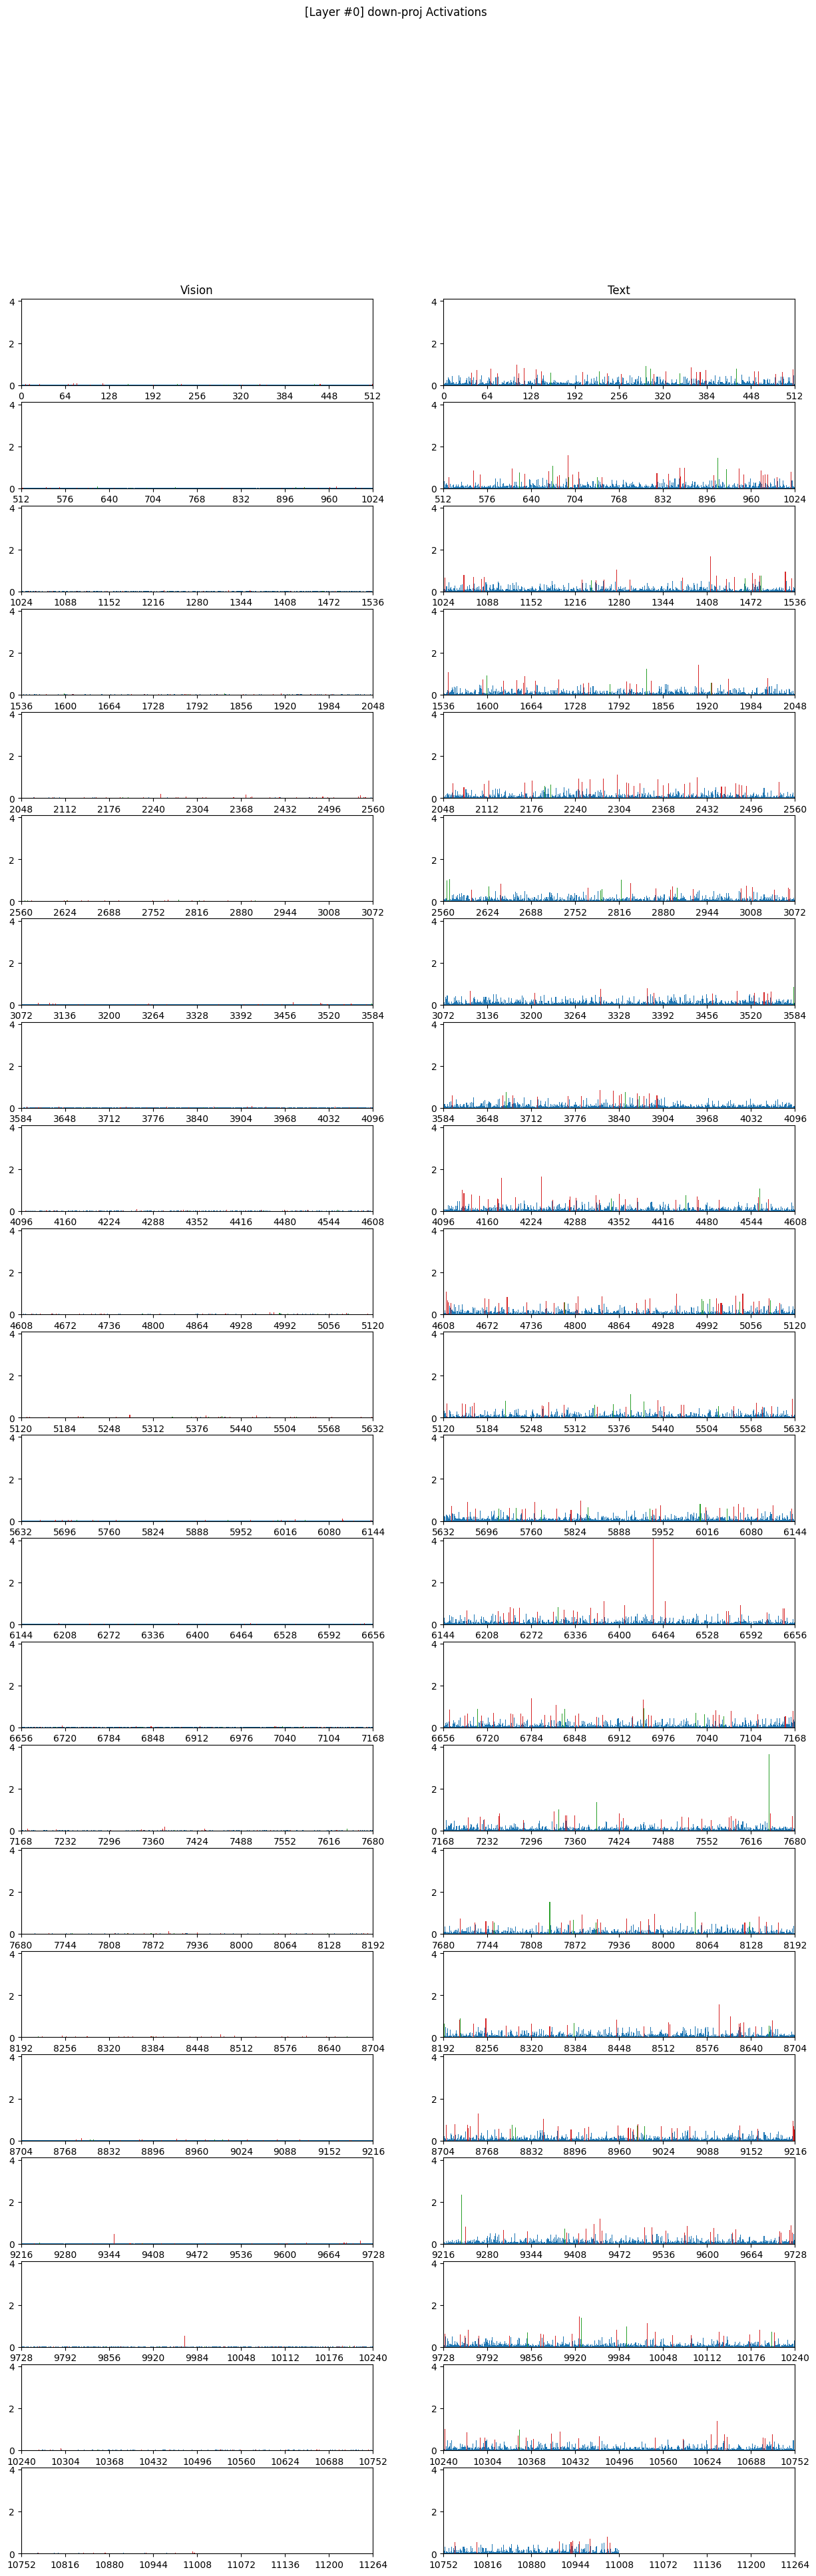

In [9]:
layer = 0
comp = 'down-proj'
vision_per_channel = torch.load(f'{act_folder}/coco/{layer:0>2}-{comp}.pt')[0].abs().max(dim=0).values.detach().cpu().numpy()
text_per_channel = torch.load(f'{act_folder}/c4/{layer:0>2}-{comp}.pt')[0].abs().max(dim=0).values.detach().cpu().numpy()
titles = [
    f'[Layer #{layer}] {comp} Activations',
    'Vision',
    'Text',
]
plot_layer_2(vision_per_channel, text_per_channel, titles, outliers_rate=0.05)

8
1415 6.008
1415 5.918


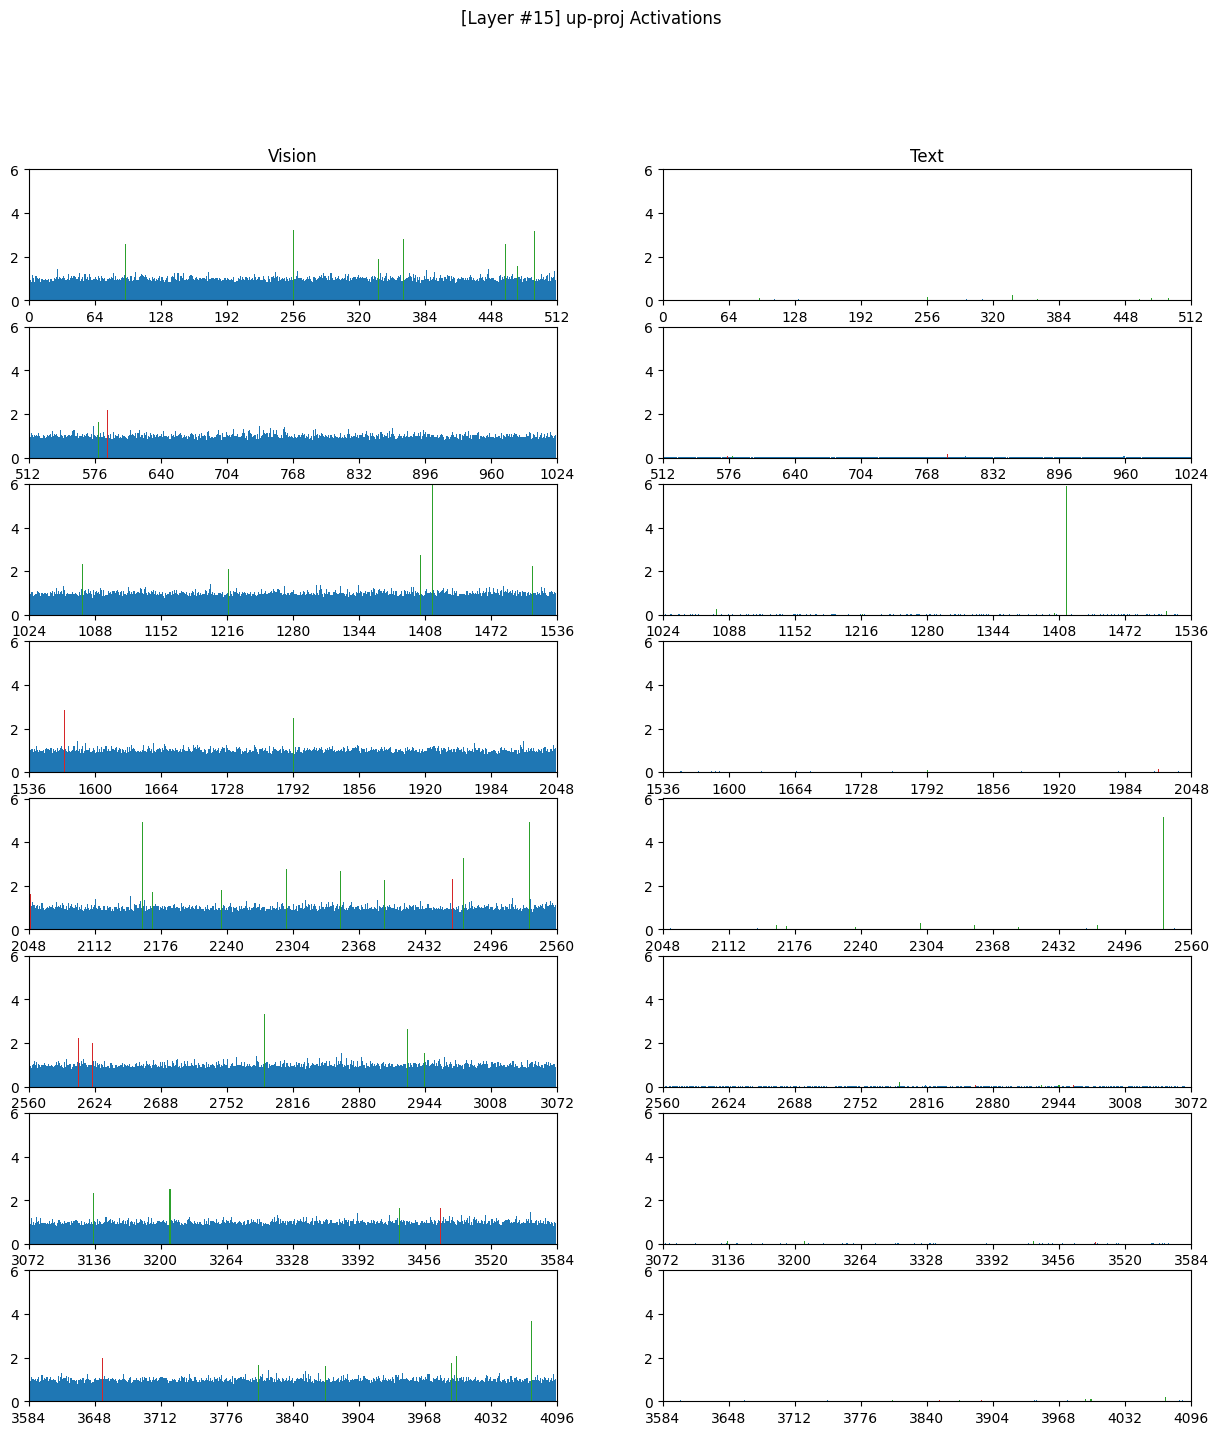

In [10]:
layer = 15
comp = 'up-proj'
vision_per_channel = torch.load(f'{act_folder}/coco/{layer:0>2}-{comp}.pt')[0].abs().max(dim=0).values.detach().cpu().numpy()
text_per_channel = torch.load(f'{act_folder}/c4/{layer:0>2}-{comp}.pt')[0].abs().max(dim=0).values.detach().cpu().numpy()
titles = [
    f'[Layer #{layer}] {comp} Activations',
    'Vision',
    'Text',
]
plot_layer_2(vision_per_channel, text_per_channel, titles, outliers_rate=0.01)

In [11]:
def load_channel(
    path: str,
    comp: str,
    channel: int,
) -> np.ndarray:
    return torch.load(f'{path}/{comp}.pt')[0, :4096, channel].cpu().numpy()


bits = 4
bins = 2 ** (bits - 1)
ticks = np.square(np.arange(-1, 1, 1 / bins))
ticks[:bins] *= -1
ticks = ticks[1:]


def plot_channel(ax: plt.Axes, x: np.ndarray, plot_ticks: bool = False, bins: int = 200):
    scale = np.abs(x).max()
    thres = scale * 0.99
    quant_x = np.where(np.abs(x) < thres, x, 0.0)
    quant_scale = np.abs(quant_x).max()
    freqs, _, _ = ax.hist(x, bins=bins)
    if plot_ticks:
        for pos in ticks:
            ax.plot([pos * quant_scale, pos * quant_scale], [0, max(freqs)], color='C1', linewidth=1)

In [14]:
def plot_all_comp(layer, channel):
    plt.figure(figsize=(15, 16))

    for i, comp in enumerate(['q-proj', 'o-proj', 'up-proj', 'down-proj']):
        title = f'[L{layer}.{comp}] C4'
        ax = plt.subplot(4, 3, i * 3 + 1)
        x = load_channel(f'{act_folder}/c4', f'{layer:0>2}-{comp}', channel)
        plot_channel(ax, x)
        ax.set_title(title)
        print(title)
        title = f'[L{layer}.{comp}] COCO'
        ax = plt.subplot(4, 3, i * 3 + 2)
        x = load_channel(f'{act_folder}/coco', f'{layer:0>2}-{comp}', channel)
        plot_channel(ax, x)
        ax.set_title(title)
        print(title)

    plt.savefig(f'./snapshot/img/activations-per-channel/{layer}.{channel}.png')

[L3.q-proj] C4
[L3.q-proj] COCO
[L3.o-proj] C4
[L3.o-proj] COCO
[L3.up-proj] C4
[L3.up-proj] COCO
[L3.down-proj] C4
[L3.down-proj] COCO


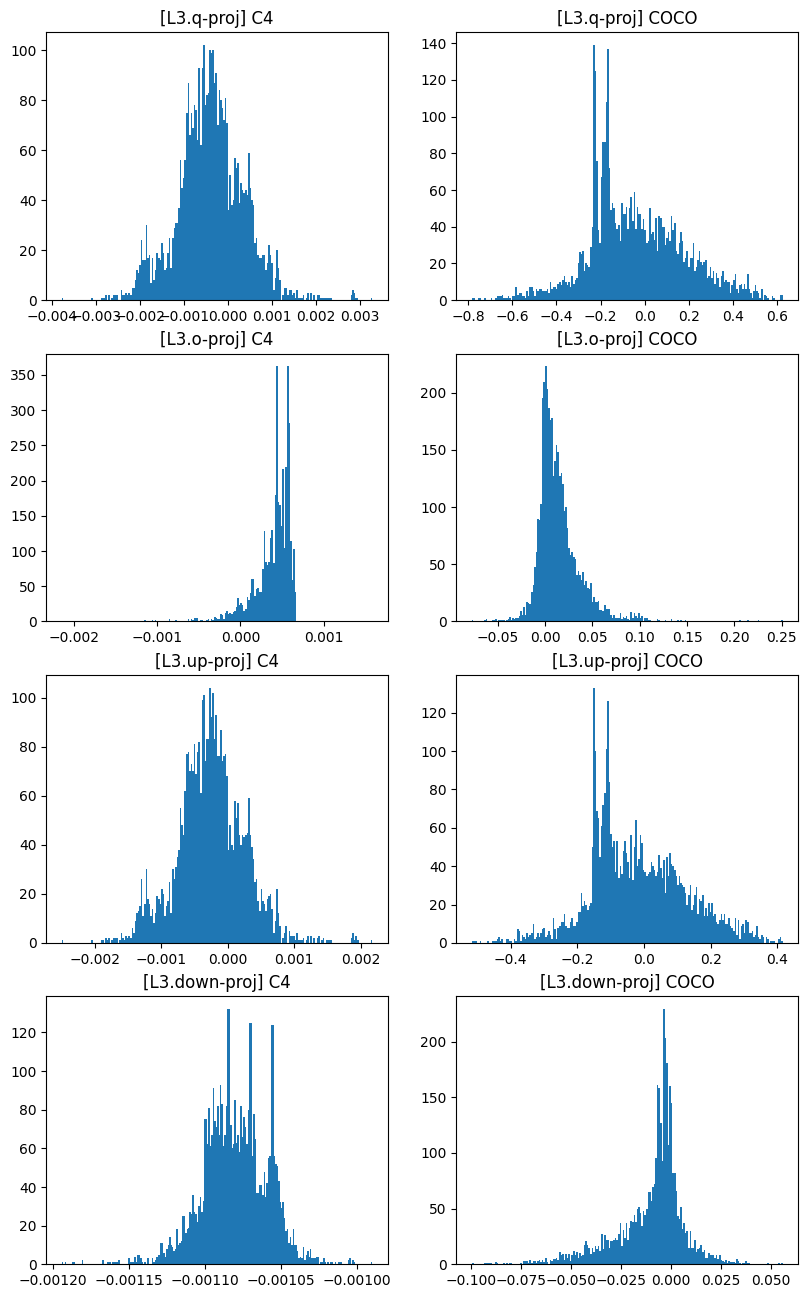

In [15]:
layer=3
plot_all_comp(layer, channel=31)